In [96]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
import codecs

In [97]:
class Stats(object):

    def __init__(self):
        self.token_count=0
        self.word_count=0
        self.tree_count=0
        self.words_with_lemma_count=0
        self.words_with_deps_count=0
        self.f_val_counter={} #key:f=val  value: count
        self.deprel_counter={} #key:deprel value: count
        
    def count_cols(self,cols):
        if cols[0].isdigit() or u"." in cols[0]: #word or empty word
            self.word_count+=1
            self.token_count+=1 #every word is also a one-word token
        else: #token
            b,e=cols[0].split(u"-")
            b,e=int(b),int(e)
            self.token_count-=e-b #every word is counted as a token, so subtract all but one to offset for that
        if cols[LEMMA]!=u"_" or (cols[LEMMA]==u"_" and cols[FORM]==u"_"):
            self.words_with_lemma_count+=1
        if cols[CPOSTAG]!=u"_":
            self.f_val_counter[u"CPOSTAG="+cols[CPOSTAG]]=self.f_val_counter.get(u"CPOSTAG="+cols[CPOSTAG],0)+1
        if cols[FEATS]!=u"_":
            for cat_is_vals in cols[FEATS].split(u"|"):
                cat,vals=cat_is_vals.split(u"=",1)
                for val in vals.split(u","):
                    self.f_val_counter[cat+u"="+val]=self.f_val_counter.get(cat+u"="+val,0)+1
        if cols[DEPREL]!=u"_":
            self.deprel_counter[cols[DEPREL]]=self.deprel_counter.get(cols[DEPREL],0)+1
        if cols[DEPS]!=u"_":
            self.words_with_deps_count+=1
            for head_and_deprel in cols[DEPS].split(u"|"):
                head,deprel=head_and_deprel.split(u":",1)
                self.deprel_counter[deprel]=self.deprel_counter.get(deprel,0)+1
    
    def print_pos_tag(self):
        pos_tag = {}
        for cat_is_val in self.f_val_counter:
            if cat_is_val.startswith(u"CPOSTAG="):
                print(cat_is_val, self.f_val_counter.get(cat_is_val))
                pos_tag[cat_is_val] = self.f_val_counter.get(cat_is_val)
        x = np.arange(len(pos_tag))
        plt.bar(x, height= pos_tag.values()) 
        plt.xticks(x, list(map(lambda x: x[8:], pos_tag.keys())))
        plt.show()
    
    def trees(self, inp):
        """
        `inp` a file-like object yielding lines as unicode

        Yields the input a tree at a time.
        """
        comments=[] #List of comment lines to go with the current tree
        lines=[] #List of token/word lines of the current tree
        for line_counter, line in enumerate(inp):
            line=line.rstrip()
            if not line: #empty line
                if lines: #Sentence done, yield. Skip otherwise.
                    yield comments, lines
                    comments=[]
                    lines=[]
            elif line[0]==u"#":
                comments.append(line)
            elif line[0].isdigit():
                cols=line.split(u"\t")
                if len(cols)!=COLCOUNT:
                    print >> sys.stderr, u"Line %d: The line has %d columns, but %d are expected. Giving up."%(line_counter+1,len(cols),COLCOUNT)
                    sys.exit(1)
                lines.append(cols)
            else: #A line which is not a comment, nor a token/word, nor empty. That's bad!
                #TODO warn!
                print >> sys.stderr, u"Line %d not conllu: Giving up."%(line_counter+1)
                sys.exit(1) #Give a non-zero exit code
        else: #end of file
            if comments or lines: #Looks like a forgotten empty line at the end of the file, well, okay...
                yield comments, lines

In [98]:
COLCOUNT=10
ID,FORM,LEMMA,CPOSTAG,POSTAG,FEATS,HEAD,DEPREL,DEPS,MISC=range(COLCOUNT)
COLNAMES=u"ID,FORM,LEMMA,CPOSTAG,POSTAG,FEATS,HEAD,DEPREL,DEPS,MISC".split(u",")

In [99]:
inp_raw=open('ru_syntagrus-ud-train.conllu',mode="rb")
inp=codecs.getreader("utf-8")(inp_raw)

In [100]:
stats=Stats()

trees = stats.trees(inp)
try:
    for comments,tree in trees:
        stats.tree_count+=1
        for cols in tree:
            stats.count_cols(cols)
except:
    traceback.print_exc()
    print >> sys.stderr, "\n\n ------- STATS MAY BE EMPTY OR INCOMPLETE ----------"
    pass

CPOSTAG=SYM 840
CPOSTAG=INTJ 78
CPOSTAG=VERB 97670
CPOSTAG=ADJ 85589
CPOSTAG=X 375
CPOSTAG=PRON 38438
CPOSTAG=PUNCT 157984
CPOSTAG=SCONJ 16219
CPOSTAG=ADV 44101
CPOSTAG=CCONJ 30432
CPOSTAG=ADP 81963
CPOSTAG=NUM 13746
CPOSTAG=PROPN 32401
CPOSTAG=AUX 6315
CPOSTAG=DET 21968
CPOSTAG=NOUN 214497
CPOSTAG=PART 27858


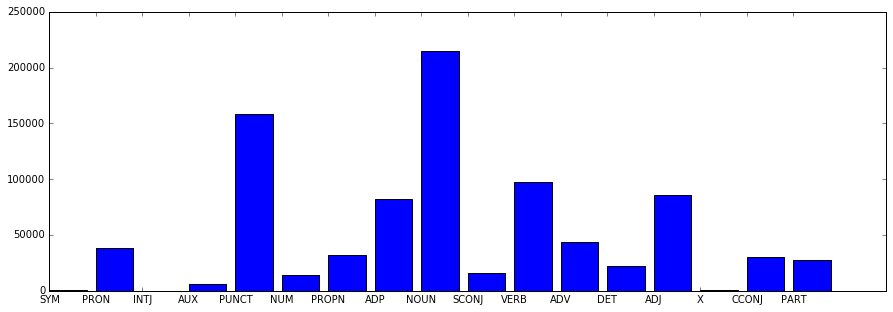

In [101]:
stats.print_pos_tag()